<a href="https://colab.research.google.com/github/brainopensource/datascience-mvp/blob/ml-analytics-mvp/MVP_Machine_Learning_%26_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVP de Machine Learning & Analytics para conclusão da Sprint da Pós-Graduação em Ciência de Dados e Analytics (PUC Rio)

# Aluno Lucas da S. Rocha

## Introdução

Este notebook apresenta o desenvolvimento de um Mínimo Produto Viável (MVP) como parte do segundo módulo da Pós-Graduação em Ciência de Dados e Analytics da PUC-Rio. Utilizando dados abertos recentes sobre a produção de petróleo e gás no Brasil, disponibilizados pela Agência Nacional de Petróleo (ANP).

## Código do MVP

### Importação de Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import hashlib
import warnings
import missingno as msno
import re

### Configuração do Ambiente

Configurações estéticas do pandas para limitar o máximo de linhas, colunas e filtrar avisos.

In [2]:
# Definindo o limite de exibição colunas de dataframe para None (sem limite)
pd.set_option('display.max_columns', 48)

# Definindo o limite de exibição de linhas de dataframe para 48
pd.set_option('display.max_rows', 48)

# Filter warnings
warnings.filterwarnings('ignore')

### Variáveis Globais

In [3]:
# Data de referência da última produção presente no dado
data_referencia = pd.to_datetime('2024-06-01')

### Funções Auxiliares

In [4]:
# Criar uma função para calcular o tempo total de produção
def calcular_producao_por_campo(df):
    # Encontrar a data mínima de produção por campo
    min_dates = df.groupby('campo')['periodo'].min()

    # Calcular o tempo de produção para cada campo, baseado na data mínima
    tempo_producao = (data_referencia - min_dates).dt.days

    # Mapear a data mínima e tempo de produção de volta para o DataFrame original
    df['data_inicio'] = df['campo'].map(min_dates)
    df['tempo_total_producao_dias'] = df['campo'].map(tempo_producao)

    return df

### Criando dataset

Conforme sugerido, os dados foram disponibilizados publicamente no repositório do Github e lidos no formato Raw

[Link do Repositório](https://github.com/brainopensource/datascience-mvp)


In [26]:
url = "https://raw.githubusercontent.com/brainopensource/datascience-mvp/refs/heads/ml-analytics-mvp/datasets/monthly_production_concat/1980_2024_BR_production_data.parquet"

df_prod_base = pd.read_parquet(url).reset_index(drop=True)

# Display the DataFrame to verify
display(df_prod_base[df_prod_base['campo'] == 'TUPI'])

print(df_prod_base.dtypes)

,estado,bacia,nome_poco_anp,campo,periodo,oleo_kbd,condensado_kbd,petroleo_kbd,gas_natural_mmscf_assoc,gas_natural_mmscf_nassoc,gas_natural_mmscf_total,agua_kbd,tempo_producao_hspormes,ano,mes
14,Rio de Janeiro,Santos,9-BRSA-716-RJS,TUPI,2011-01-01,13.188175,0.0,13.188175,21.049140,0.0,21.049140,0.0,0,2011,1
30,Rio de Janeiro,Santos,9-BRSA-716-RJS,TUPI,2011-02-01,14.871802,0.0,14.871802,24.602713,0.0,24.602713,0.0,0,2011,2
37,Rio de Janeiro,Santos,9-BRSA-716-RJS,TUPI,2011-03-01,14.601435,0.0,14.601435,24.307998,0.0,24.307998,0.0,0,2011,3
54,Rio de Janeiro,Santos,9-BRSA-716-RJS,TUPI,2011-04-01,21.318976,0.0,21.318976,36.219512,0.0,36.219512,0.0,0,2011,4
72,Rio de Janeiro,Santos,9-BRSA-716-RJS,TUPI,2011-05-01,28.436432,0.0,28.436432,44.274315,0.0,44.274315,0.0,0,2011,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308780,Rio de Janeiro,Santos,3-BRSA-755A-RJS,TUPI,2011-07-01,14.384300,0.0,14.384300,18.831818,0.0,18.831818,0.0,0,2011,7
309862,Rio de Janeiro,Santos,3-BRSA-755A-RJS,TUPI,2011-08-01,13.431932,0.0,13.431932,17.835753,0.0,17.835753,0.0,0,2011,8
309918,Rio de Janeiro,Santos,3-BRSA-755A-RJS,TUPI,2011-09-01,11.567170,0.0,11.567170,15.574210,0.0,15.574210,0.0,0,2011,9
310818,Rio de Janeiro,Santos,3-BRSA-755A-RJS,TUPI,2011-10-01,11.464911,0.0,11.464911,16.949926,0.0,16.949926,0.0,0,2011,10


estado                              object
bacia                               object
nome_poco_anp                       object
campo                               object
periodo                     datetime64[ns]
oleo_kbd                           float64
condensado_kbd                     float64
petroleo_kbd                       float64
gas_natural_mmscf_assoc            float64
gas_natural_mmscf_nassoc           float64
gas_natural_mmscf_total            float64
agua_kbd                           float64
tempo_producao_hspormes              int64
ano                                  int32
mes                                  int32
dtype: object


In [27]:
# Listar todos os campos presentes no df_fields_prod
df_prod = df_prod_base.copy(deep=True)
campos = df_prod['campo'].unique()

import pandas as pd
from google.colab import files

# Salve o DataFrame em um arquivo CSV
df_prod_base.to_csv('df_prod_base.csv', index=False)

# Baixe o arquivo CSV
files.download('df_prod_base.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Transformações de dado

In [7]:
df_prod['periodo'] = pd.to_datetime(df_prod['periodo'], errors='coerce')

# Criar um mapeamento único de campo -> bacia
bacia_por_campo = df_prod[['campo', 'bacia']].drop_duplicates().set_index('campo')

# Agrupamento, sem 'bacia' diretamente
df_fields_prod = df_prod.groupby(['campo', 'periodo']).agg(
    oleo_kbd_total=('oleo_kbd', 'sum'),
    condensado_kbd_total=('condensado_kbd', 'sum'),
    petroleo_kbd_total=('petroleo_kbd', 'sum'),
    gas_natural_mmscf_assoc_total=('gas_natural_mmscf_assoc', 'sum'),
    gas_natural_mmscf_nassoc_total=('gas_natural_mmscf_nassoc', 'sum'),
    gas_natural_mmscf_total_total=('gas_natural_mmscf_total', 'sum'),
    agua_kbd_total=('agua_kbd', 'sum'),
    tempo_producao_hspormes_total=('tempo_producao_hspormes', 'sum')
).reset_index()

# Adicionar a coluna 'bacia' ao resultado final a partir do mapeamento
df_fields_prod['bacia'] = df_fields_prod['campo'].map(bacia_por_campo['bacia'])

# Exibir o DataFrame auxiliar
display(df_fields_prod.head(2))

,campo,periodo,oleo_kbd_total,condensado_kbd_total,petroleo_kbd_total,gas_natural_mmscf_assoc_total,gas_natural_mmscf_nassoc_total,gas_natural_mmscf_total_total,agua_kbd_total,tempo_producao_hspormes_total,bacia
0,ABALONE,2009-07-01,1.019355,0.0,1.019355,3.605638,0.0,3.605638,0.0,292,Campos
1,ABALONE,2009-08-01,0.670778,0.0,0.670778,2.061891,0.0,2.061891,0.0,178,Campos


In [8]:
# Calcular a produção acumulada por campo e período
df_fields_prod['producao_acumulada'] = df_fields_prod.groupby('campo')['petroleo_kbd_total'].cumsum()

df_fields_prod.sort_values(by=['periodo', 'campo'], inplace=True)

In [9]:
# Aplicar a função ao DataFrame
df_fields_prod = calcular_producao_por_campo(df_fields_prod)

# Exibir as primeiras linhas para verificar as novas colunas
display(df_fields_prod.head(2))

,campo,periodo,oleo_kbd_total,condensado_kbd_total,petroleo_kbd_total,gas_natural_mmscf_assoc_total,gas_natural_mmscf_nassoc_total,gas_natural_mmscf_total_total,agua_kbd_total,tempo_producao_hspormes_total,bacia,producao_acumulada,data_inicio,tempo_total_producao_dias
180,AGULHA,1980-01-01,5.687206,0.0,5.687206,3.063783,0.0,3.063783,0.113075,0,Potiguar,5.687206,1980-01-01,16223
2512,AREA DO SES-2,1980-01-01,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0,Sergipe,0.000000,1980-01-01,16223


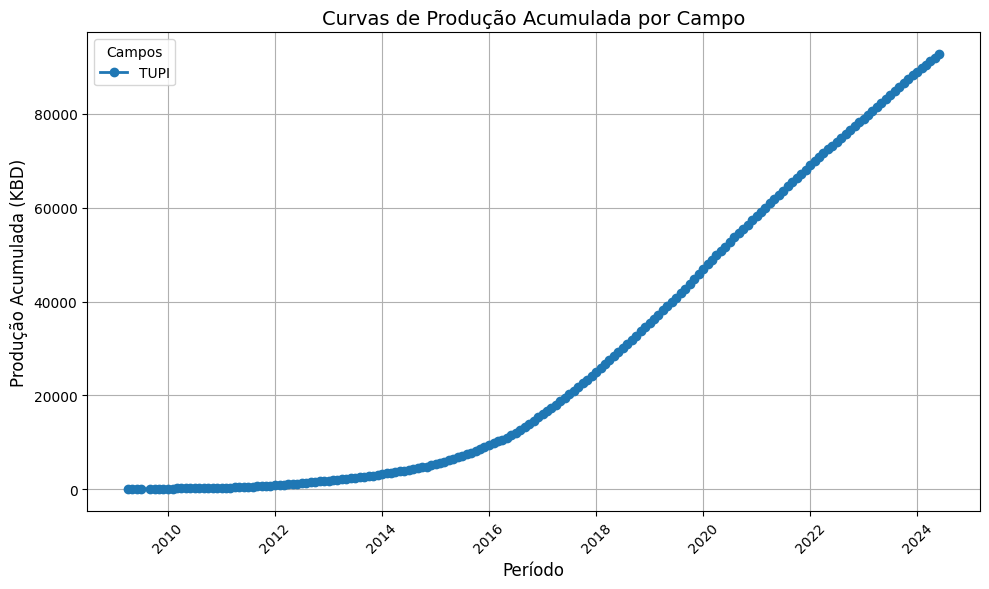

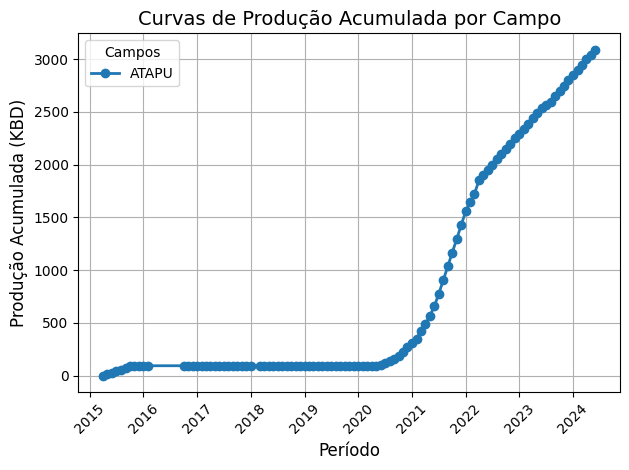

In [10]:
# Definir os campos para plotagem (substitua por campos específicos ou dinâmicos)
campos_para_plotar = ['ABALONE', 'AGULHA', 'ALBACORA LESTE', 'ANEQUIM', 'ARABAIANA',
 'ARATUM', 'ARGONAUTA', 'ATAPU', 'ATAPU_ECO', 'ATLANTA', 'ATUM', 'CAMARUPIM NORTE', 'CAMORIM', 'CANAPU',
 'CANDEIAS', 'CANGOÁ', 'CARAPEBA', 'CARATINGA', 'CARAVELA', 'CARAÚNA', 'CAVALA',
 'CAVALO-MARINHO', 'CAÇÃO', 'CHERNE', 'CIOBA', 'CONGRO', 'CORAL', 'CORVINA',
 'CURIMÃ', 'DENTÃO', 'DOM JOÃO', 'DOM JOÃO MAR', 'DOURADO', 'ENCHOVA',
 'ENCHOVA OESTE', 'ESPADA', 'ESPADARTE', 'ESPADIM', 'ESTRELA DO MAR', 'FRADE',
 'GAROUPA', 'GAROUPINHA', 'GOLFINHO', 'GUARICEMA', 'ITAPARICA', 'ITAPU',
 'ITAPU_ECO', 'LAGOSTA', 'LAPA', 'LINGUADO', 'MACAU', 'MALHADO',
 'MANATI', 'MARIMBÁ', 'MARLIM LESTE', 'MERLUZA', 'MERO',
 'MEXILHÃO', 'MORÉIA', 'NAMORADO', 'NORDESTE DE NAMORADO',
 'NORDESTE DE SAPINHOÁ', 'NOROESTE DE SAPINHOÁ', 'NORTE DE PESCADA',
 'OESTE DE ATAPU', 'OESTE DE UBARANA', 'OSTRA', 'PAMPO', 'PAPA-TERRA', 'PARATI',
 'PARGO', 'PARU', 'PEREGRINO', 'PEROÁ',
 'PESCADA', 'PIRACABA', 'PIRAMBU', 'PIRANEMA', 'PIRANEMA SUL', 'PIRAÚNA',
 'PITANGOLA', 'POLVO', 'ROBALO', 'SALEMA', 'SALGO', 'SERRA', 'SUDOESTE DE SAPINHOÁ', 'SUL DE BERBIGÃO', 'SUL DE TUPI', 'SURURU',
 'SÉPIA', 'SÉPIA LESTE', 'SÉPIA_ECO', 'TAMBAÚ', 'TAMBUATÁ', 'TARTARUGA',
 'TARTARUGA MESTIÇA', 'TARTARUGA VERDE', 'TARTARUGA VERDE SUDOESTE', 'TATUI',
 'TRILHA', 'TUBARÃO AZUL', 'TUBARÃO MARTELO', 'UBARANA', 'URUGUÁ',
 'VERMELHO', 'VIOLA', 'VOADOR', 'XARÉU']


# Criar um gráfico para cada campo
plt.figure(figsize=(10, 6))

# Plotar a produção acumulada de cada campo na lista
#for campo in campos_para_plotar:
for campo in ['TUPI', 'ATAPU']:
    df_campo = df_fields_prod[df_fields_prod['campo'] == campo]
    plt.plot(df_campo['periodo'], df_campo['producao_acumulada'], label=campo, linestyle='-', marker='o', linewidth=2)

    # Adicionar título, rótulos e legenda
    plt.title('Curvas de Produção Acumulada por Campo', fontsize=14)
    plt.xlabel('Período', fontsize=12)
    plt.ylabel('Produção Acumulada (KBD)', fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(title='Campos', loc='upper left')

    # Exibir o gráfico
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
# Step 1: Import required module
#from google.colab import files

# Step 2: Save your DataFrame to a CSV file
#df_fields_prod.to_csv('df_fields_prod.csv')

# Step 3: Download the file to your local machine
#files.download('df_fields_prod.csv')

### MACHINE LEARNING

In [30]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#### Linear Regression Model

Selecionar as colunas: campo, oleo_kbd_total, tempo_total_producao_dias, producao_acumulada.

Limpar e preparar os dados: tratar valores ausentes e transformar a coluna campo (codificação categórica).

Dividir o dataset: separar em treino e teste (e validação, se necessário).

Pré-processar os dados: normalizar ou padronizar se necessário.

Treinar o modelo: aplicar regressão linear com os dados de treino.

Avaliar o modelo: calcular métricas como MAE, MSE e R².

Visualizar os resultados: comparar previsões com valores reais e analisar resíduos.

In [28]:
from sklearn.linear_model import LinearRegression


print(df_fields_prod.dtypes)

display(df_fields_prod.head(2))

# Selecionando as colunas relevantes
df_fields = df_fields_prod[['campo', 'bacia', 'periodo', 'tempo_total_producao_dias', 'oleo_kbd_total']]

display(df_fields.head(2))

campo                                     object
periodo                           datetime64[ns]
oleo_kbd_total                           float64
condensado_kbd_total                     float64
petroleo_kbd_total                       float64
gas_natural_mmscf_assoc_total            float64
gas_natural_mmscf_nassoc_total           float64
gas_natural_mmscf_total_total            float64
agua_kbd_total                           float64
tempo_producao_hspormes_total              int64
bacia                                     object
producao_acumulada                       float64
data_inicio                       datetime64[ns]
tempo_total_producao_dias                  int64
dtype: object


,campo,periodo,oleo_kbd_total,condensado_kbd_total,petroleo_kbd_total,gas_natural_mmscf_assoc_total,gas_natural_mmscf_nassoc_total,gas_natural_mmscf_total_total,agua_kbd_total,tempo_producao_hspormes_total,bacia,producao_acumulada,data_inicio,tempo_total_producao_dias
180,AGULHA,1980-01-01,5.687206,0.0,5.687206,3.063783,0.0,3.063783,0.113075,0,Potiguar,5.687206,1980-01-01,16223
2512,AREA DO SES-2,1980-01-01,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0,Sergipe,0.000000,1980-01-01,16223


,campo,bacia,periodo,tempo_total_producao_dias,oleo_kbd_total
180,AGULHA,Potiguar,1980-01-01,16223,5.687206
2512,AREA DO SES-2,Sergipe,1980-01-01,16223,0.000000


In [13]:
print(df_fields['campo'].unique())

['AGULHA' 'AREA DO SES-2' 'BONITO' 'CAIOBA' 'CAMORIM' 'CANDEIAS' 'CAÇÃO'
 'DOM JOÃO MAR' 'DOURADO' 'ENCHOVA' 'GAROUPA' 'GUARICEMA' 'NAMORADO'
 'ROBALO' 'UBARANA' 'AREA do BAS-37 (Licitado)' 'CURIMÃ' 'GAROUPINHA'
 'PAMPO' 'XARÉU' 'BADEJO' 'LINGUADO' 'BICUDO' 'DOM JOÃO' 'AREA DO RNS-36'
 'TATUI' 'ESPADA' 'ITAPARICA' 'PARATI' 'CORVINA' 'ATUM' 'CHERNE' 'PIRAÚNA'
 'TRILHA' 'BAGRE' 'ÁREA DO RJS-150' 'ENCHOVA OESTE' 'ANEQUIM' 'VIOLA'
 'MARIMBÁ' 'MORÉIA' 'SALGO' 'ARATUM' 'ALBACORA' 'NORDESTE DE NAMORADO'
 'CARAPEBA' 'PARGO' 'VERMELHO' 'MALHADO' 'MARLIM' 'CORAL' 'MERLUZA'
 'CONGRO' 'VOADOR' 'BIJUPIRÁ' 'CARAVELA' 'SALEMA' 'MARLIM SUL'
 'CAVALO-MARINHO' 'TARTARUGA' 'ÁREA DO BAS-60' 'ESTRELA DO MAR' 'PARU'
 'SERRA' 'CARAÚNA' 'BARRACUDA' 'CARATINGA' 'ALBACORA LESTE' 'RONCADOR'
 'PESCADA' 'MARLIM LESTE' 'ESPADARTE' 'ARABAIANA' 'DENTÃO' 'JUBARTE'
 'NORTE DE PESCADA' 'OESTE DE UBARANA' 'CIOBA' 'GOLFINHO' 'PEROÁ' 'MANATI'
 'POLVO' 'PIRANEMA' 'BIQUARA' 'CACHALOTE' 'FRADE' 'LAGOSTA' 'TUPI'
 'CAMARUPIM' '

In [14]:
# Criando dois encoders distintos
label_encoder_campo = LabelEncoder()
label_encoder_bacia = LabelEncoder()

# Codificando as variáveis categóricas separadamente
df_fields['campo'] = label_encoder_campo.fit_transform(df_fields['campo'])
df_fields['bacia'] = label_encoder_bacia.fit_transform(df_fields['bacia'])

# Exibindo o DataFrame para ver a codificação
display(df_fields.head(2))

# Exibindo as classes codificadas de cada coluna
print("Classes codificadas para 'campo':")
print(label_encoder_campo.classes_)

print("Classes codificadas para 'bacia':")
print(label_encoder_bacia.classes_)

,campo,bacia,periodo,tempo_total_producao_dias,oleo_kbd_total
180,1,7,1980-01-01,16223,5.687206
2512,8,10,1980-01-01,16223,0.000000


Classes codificadas para 'campo':
['ABALONE' 'AGULHA' 'ALBACORA' 'ALBACORA LESTE' 'ANEQUIM' 'ARABAIANA'
 'ARATUM' 'AREA DO RNS-36' 'AREA DO SES-2' 'AREA do BAS-37 (Licitado)'
 'ARGONAUTA' 'ATAPU' 'ATAPU_ECO' 'ATLANTA' 'ATUM' 'AnC_BRAVA' 'AnC_Forno'
 'AnC_MERO' 'AnC_NORTE_ATAPU' 'AnC_TARTARUGA VERDE' 'AnC_TUPI' 'BADEJO'
 'BAGRE' 'BALEIA ANÃ' 'BALEIA AZUL' 'BALEIA FRANCA' 'BARRACUDA' 'BAÚNA'
 'BERBIGÃO' 'BICUDO' 'BIJUPIRÁ' 'BIQUARA' 'BONITO' 'BÚZIOS' 'BÚZIOS_ECO'
 'CACHALOTE' 'CAIOBA' 'CAMARUPIM' 'CAMARUPIM NORTE' 'CAMORIM' 'CANAPU'
 'CANDEIAS' 'CANGOÁ' 'CARAPEBA' 'CARATINGA' 'CARAVELA' 'CARAÚNA' 'CAVALA'
 'CAVALO-MARINHO' 'CAÇÃO' 'CHERNE' 'CIOBA' 'CONGRO' 'CORAL' 'CORVINA'
 'CURIMÃ' 'DENTÃO' 'DOM JOÃO' 'DOM JOÃO MAR' 'DOURADO' 'ENCHOVA'
 'ENCHOVA OESTE' 'ESPADA' 'ESPADARTE' 'ESPADIM' 'ESTRELA DO MAR' 'FRADE'
 'GAROUPA' 'GAROUPINHA' 'GOLFINHO' 'GUARICEMA' 'ITAPARICA' 'ITAPU'
 'ITAPU_ECO' 'JUBARTE' 'LAGOSTA' 'LAPA' 'LINGUADO' 'MACAU' 'MALHADO'
 'MANATI' 'MARIMBÁ' 'MARLIM' 'MARLIM LESTE' '

In [15]:
#Conversão de periodo para Número de Dias
base_date = pd.to_datetime('1980-01-01')

df_fields['periodo'] = (df_fields['periodo'] - base_date).dt.days

In [16]:
display(df_fields.head(2))

,campo,bacia,periodo,tempo_total_producao_dias,oleo_kbd_total
180,1,7,0,16223,5.687206
2512,8,10,0,16223,0.000000


In [17]:
#Separação de Variáveis Independentes (X) e Dependente (y)
#X = df_fields[['campo', 'periodo', 'tempo_total_producao_dias', 'bacia']]
X = df_fields[['campo', 'periodo']

y = df_fields['oleo_kbd_total']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'R2: {r2}')

MAE: 27.938342545978443
MSE: 5054.321987634521
R2: 0.04210876486503368


In [20]:
# Procurar o índice do valor 'TUPI'
indice = list(label_encoder_campo.classes_).index('TUPI')
print(f"O índice de 'TUPI' na lista é: {indice}")

bacia_code = list(label_encoder_bacia.classes_).index('Santos')
print(f"Código para 'SANTOS': {bacia_code}")

O índice de 'TUPI' na lista é: 136
Código para 'SANTOS': 9


In [21]:
# Exemplo de dado de entrada para previsão
campo = 136  # O nome do campo para o qual você deseja fazer a previsão
data_futura = pd.to_datetime('2025-01-01')  # A data futura que você quer prever

# Codificar 'campo' e 'bacia' da mesma forma que foi feito no treinamento
# Certifique-se de que 'label_encoder_campo' e 'label_encoder_bacia' são os codificadores corretos
campo_encoded = label_encoder_campo.transform(['TUPI'])[0]  # Codificando o campo
bacia_encoded = label_encoder_bacia.transform(['Santos'])[0]  # Codificando a bacia

# Converter 'periodo' para número de dias desde a base
tempo_total_producao_dias = (data_futura - base_date).days
periodo = tempo_total_producao_dias  # A data futura pode ser considerada o 'periodo'

# Preparar os dados para a previsão (todas as variáveis independentes)
# Adicionando o 'periodo' e garantindo que o número de variáveis está correto
X_novo = np.array([[campo_encoded, periodo, tempo_total_producao_dias, bacia_encoded]])

# Realizar a previsão
y_pred_futuro = model.predict(X_novo)

print(f'Previsão para a produção de óleo para o campo {campo} na data {data_futura}: {y_pred_futuro[0]}')

Previsão para a produção de óleo para o campo 136 na data 2025-01-01 00:00:00: 10.133670347482969


#### GradientBoostingRegressor

In [37]:
from sklearn.ensemble import GradientBoostingRegressor

print(df_fields_prod.dtypes)

display(df_fields_prod.head(2))

# Selecionando as colunas relevantes
df_fields = df_fields_prod[['campo', 'bacia', 'periodo', 'tempo_total_producao_dias', 'oleo_kbd_total']]

display(df_fields.head(2))

campo                                     object
periodo                           datetime64[ns]
oleo_kbd_total                           float64
condensado_kbd_total                     float64
petroleo_kbd_total                       float64
gas_natural_mmscf_assoc_total            float64
gas_natural_mmscf_nassoc_total           float64
gas_natural_mmscf_total_total            float64
agua_kbd_total                           float64
tempo_producao_hspormes_total              int64
bacia                                     object
producao_acumulada                       float64
data_inicio                       datetime64[ns]
tempo_total_producao_dias                  int64
dtype: object


,campo,periodo,oleo_kbd_total,condensado_kbd_total,petroleo_kbd_total,gas_natural_mmscf_assoc_total,gas_natural_mmscf_nassoc_total,gas_natural_mmscf_total_total,agua_kbd_total,tempo_producao_hspormes_total,bacia,producao_acumulada,data_inicio,tempo_total_producao_dias
180,AGULHA,1980-01-01,5.687206,0.0,5.687206,3.063783,0.0,3.063783,0.113075,0,Potiguar,5.687206,1980-01-01,16223
2512,AREA DO SES-2,1980-01-01,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0,Sergipe,0.000000,1980-01-01,16223


,campo,bacia,periodo,tempo_total_producao_dias,oleo_kbd_total
180,AGULHA,Potiguar,1980-01-01,16223,5.687206
2512,AREA DO SES-2,Sergipe,1980-01-01,16223,0.000000


In [38]:
# Codificando a variável 'campo'
campo_encoder = LabelEncoder()
df_fields['campo'] = campo_encoder.fit_transform(df_fields['campo'])

# Codificando a variável 'bacia'
bacia_encoder = LabelEncoder()
df_fields['bacia'] = bacia_encoder.fit_transform(df_fields['bacia'])

display(df_fields.head(2))

,campo,bacia,periodo,tempo_total_producao_dias,oleo_kbd_total
180,1,7,1980-01-01,16223,5.687206
2512,8,10,1980-01-01,16223,0.000000


In [39]:
# Variáveis independentes (X)
X = df_fields[['campo', 'bacia', 'tempo_total_producao_dias']]

# Variável dependente (y)
y = df_fields['oleo_kbd_total']

In [40]:
# Divisão treino-teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelo Gradient Boosting
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X_train, y_train)

GradientBoostingRegressor(random_state=42)

In [41]:
# Previsões e avaliação
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'R²: {r2}')

MAE: 15.9858336450491
MSE: 2142.02158062685
R²: 0.5940457092816355


In [47]:
# Exemplo de dado de entrada para previsão
campo = 'PEREGRINO'  # Nome do campo
data_futura = pd.to_datetime('2025-01-01')  # A data futura que você quer prever

# Codificar 'campo' e 'bacia' da mesma forma que foi feito no treinamento
campo_encoded = label_encoder_campo.transform([campo])[0]  # Codificando o campo
bacia_encoded = label_encoder_bacia.transform(['Santos'])[0]  # Codificando a bacia

# Converter 'periodo' para número de dias desde a base (base_date é a data inicial usada no treinamento)
tempo_total_producao_dias = (data_futura - base_date).days

# Preparar os dados para a previsão (somente as 3 variáveis que foram usadas no treinamento)
X_novo = np.array([[campo_encoded, bacia_encoded, tempo_total_producao_dias]])

# Realizar a previsão usando o modelo Gradient Boosting
y_pred_futuro = model.predict(X_novo)

# Exibir a previsão
print(f'Previsão para a produção de óleo para o campo {campo} na data {data_futura}: {y_pred_futuro[0]}')

Previsão para a produção de óleo para o campo PEREGRINO na data 2025-01-01 00:00:00: -0.6530823520100135
